In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde
import scipy.ndimage as ndimage
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import os

In [2]:
indir_flats = '../output_fits/{0}_run/'

In [3]:
filters = ['FELH0600','BG40','SDSSg']
date_dict = {'SDSSg':'20220608','SDSSr':'','empty':'','BG40':'20220608','FELH0600':'20220608'}

In [4]:
indir_dict = {}
for filter in filters:
    indir_dict[filter] = '../output_fits/{0}_run/'.format(date_dict[filter])
print(indir_dict)

filter_files = {}
for filter in filters:
    filter_files[filter] = [f for f in os.listdir(indir_flats.format(date_dict[filter])) if 'master_flat_median_{0}_{1}'.format(date_dict[filter],filter) in f and '_renormalised.fits' in f and 'ratio' not in f][0]
print(filter_files)

{'FELH0600': '../output_fits/20220608_run/', 'BG40': '../output_fits/20220608_run/', 'SDSSg': '../output_fits/20220608_run/'}
{'FELH0600': 'master_flat_median_20220608_FELH0600_87_167_renormalised.fits', 'BG40': 'master_flat_median_20220608_BG40_66_86_renormalised.fits', 'SDSSg': 'master_flat_median_20220608_SDSSg_45_65_renormalised.fits'}


In [6]:
filter1 = 'FELH0600' # Redder filter 
filter2 = 'BG40' # Bluer filter 

In [8]:
outdir_plots = '../output_plots/{0}_{1}_{2}_{3}_run/'.format(filter1,date_dict[filter1],filter2,date_dict[filter2])
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [3]:
fredhf = fits.open(indir_dict[filter1]+filter_files[filter1])
fbluehf = fits.open(indir_dict[filter2]+filter_files[filter2])
ratio = fits.open(indir_dict[filter1]+'ratio_master_flat_median_{0}_{1}_{2}_{3}_renormalised_high_frequency.fits'.format(filter1,date_dict[filter1],filter2,date_dict[filter2]))

In [5]:
num_segments = 16
shape0 = fredhf[1].data.shape
hprescan = 3
hoverscan = 64
voverscan = 48

In [6]:
def pearson_coeff(x,y):
    std_x = np.std(x)
    std_y = np.std(y)
    cov_xy = np.cov(x,y)[0,1]
    coeff = cov_xy/(std_x*std_y)
    return coeff

In [7]:
def density_scatter( x , y, ax = None, sort = True, bins = 20, range=None, **kwargs )   :
        """
        Scatter plot colored by 2d histogram
        """
        if ax is None :
                fig , ax = plt.subplots(figsize=(10,10))
        if range is None:
                data , x_e, y_e = np.histogram2d( x, y, bins = bins)
        else:
                data , x_e, y_e = np.histogram2d( x, y, bins = bins, range=range)
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

        # Sort the points by density, so that the densest points are plotted last
        if sort :
                idx = z.argsort()
                x, y, z = x[idx], y[idx], z[idx]

        plt.scatter( x, y, c=z, **kwargs )
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize='large')
        return ax

In [8]:
def density_scatter2( x , y, fig = None, ax = None, sort = True, bins = 20, range=None, **kwargs )   :
        """
        Scatter plot colored by 2d histogram
        """
        if ax is None :
                fig , ax = plt.subplots(figsize=(10,10))
        if range is None:
                data , x_e, y_e = np.histogram2d( x, y, bins = bins)
        else:
                data , x_e, y_e = np.histogram2d( x, y, bins = bins, range=range)
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

        # Sort the points by density, so that the densest points are plotted last
        if sort :
                idx = z.argsort()
                x, y, z = x[idx], y[idx], z[idx]

        im = ax.scatter( x, y, c=z, **kwargs )
        cb = fig.colorbar(im,ax=ax)
        cb.ax.tick_params()#labelsize='large')
        return ax

# Basic checks 

In [9]:
for seg in range(1,num_segments+1):
    print(seg)
    
    assert (fredhf[seg].header['EXTNAME']==ratio[seg].header['EXTNAME'])
    assert (fbluehf[seg].header['EXTNAME']==ratio[seg].header['EXTNAME'])
    print(fredhf[seg].header['EXTNAME'])
    
    dred = fredhf[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    dblue = fbluehf[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    dratio = ratio[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    assert (dred.ravel()/dblue.ravel()==dratio.ravel()).all()

1
Segment00
2
Segment01
3
Segment02
4
Segment03
5
Segment04
6
Segment05
7
Segment06
8
Segment07
9
Segment17
10
Segment16
11
Segment15
12
Segment14
13
Segment13
14
Segment12
15
Segment11
16
Segment10


# Obtain histograms and 2D plots per register 

In [10]:
xmin = 0.95
xmax = 1.05

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


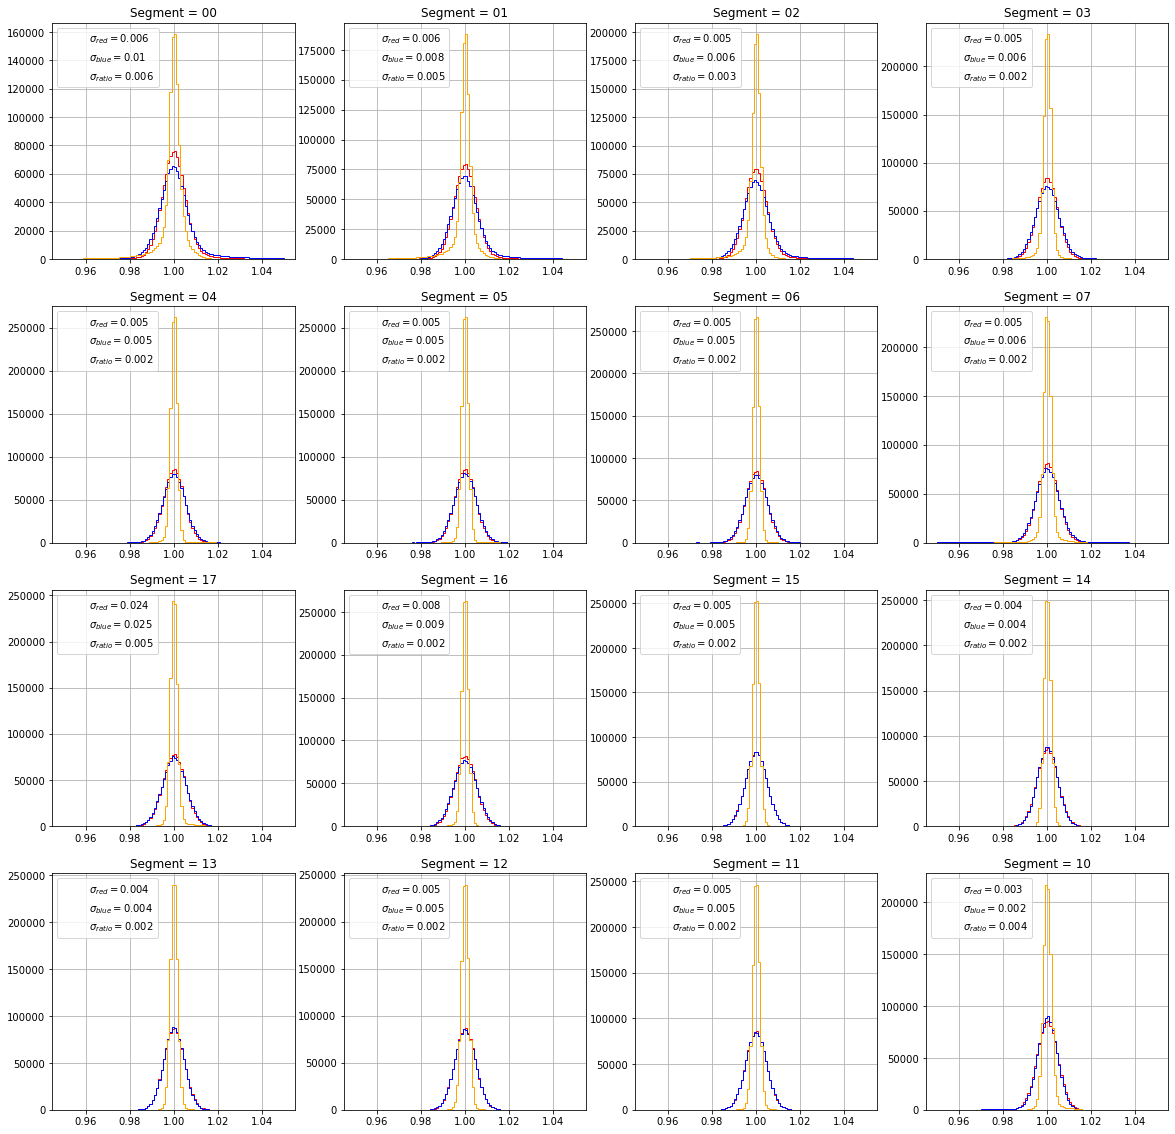

In [11]:
fig, axs = plt.subplots(4, 4, figsize=(20,20))

for seg in range(num_segments):
    print(seg)
    
    dred = fredhf[seg+1].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan].ravel()
    dblue = fbluehf[seg+1].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan].ravel()
    dratio = ratio[seg+1].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan].ravel()
    seg_label = fredhf[seg+1].header['EXTNAME'][-2:]
    
    ######################################## Shifts added to center the histograms around median = 1 
    dred_shift = np.median(dred)-1.
    dblue_shift = np.median(dblue)-1.
    dratio_shift = np.median(dratio)-1.
    ########################################
    
    rmask = (dred>=xmin)*(dred<=xmax)
    bmask = (dblue>=xmin)*(dblue<=xmax)
    ratiomask = rmask*bmask
    
    rstd = np.std(dred[ratiomask])
    bstd = np.std(dblue[ratiomask])
    ratiostd = np.std(dratio[ratiomask])
    
    if seg<4:
        j = seg
        axs[0,j].hist(dred-dred_shift,bins=100,range=(xmin,xmax),histtype='step',color='r')
        axs[0,j].hist(dblue-dblue_shift,bins=100,range=(xmin,xmax),histtype='step',color='b')
        axs[0,j].hist(dratio-dratio_shift,bins=100,range=(xmin,xmax),histtype='step',color='orange')
        axs[0,j].grid()
        axs[0,j].set_title('Segment = {0}'.format(seg_label))
        axs[0,j].plot([],[],ls='',label=r'$\sigma_{red} = $'+'{0}'.format(rstd.round(3)))
        axs[0,j].plot([],[],ls='',label=r'$\sigma_{blue} = $'+'{0}'.format(bstd.round(3)))
        axs[0,j].plot([],[],ls='',label=r'$\sigma_{ratio} = $'+'{0}'.format(ratiostd.round(3)))
        axs[0,j].legend(loc='upper left',fontsize=10)
    elif seg>=4 and seg<8:
        j = seg-4
        axs[1,j].hist(dred-dred_shift,bins=100,range=(xmin,xmax),histtype='step',color='r')
        axs[1,j].hist(dblue-dblue_shift,bins=100,range=(xmin,xmax),histtype='step',color='b')
        axs[1,j].hist(dratio-dratio_shift,bins=100,range=(xmin,xmax),histtype='step',color='orange')
        axs[1,j].grid()
        axs[1,j].set_title('Segment = {0}'.format(seg_label))
        axs[1,j].plot([],[],ls='',label=r'$\sigma_{red} = $'+'{0}'.format(rstd.round(3)))
        axs[1,j].plot([],[],ls='',label=r'$\sigma_{blue} = $'+'{0}'.format(bstd.round(3)))
        axs[1,j].plot([],[],ls='',label=r'$\sigma_{ratio} = $'+'{0}'.format(ratiostd.round(3)))
        axs[1,j].legend(loc='upper left',fontsize=10)
    elif seg>=8 and seg<12:
        j = seg-8
        axs[2,j].hist(dred-dred_shift,bins=100,range=(xmin,xmax),histtype='step',color='r')
        axs[2,j].hist(dblue-dblue_shift,bins=100,range=(xmin,xmax),histtype='step',color='b')
        axs[2,j].hist(dratio-dratio_shift,bins=100,range=(xmin,xmax),histtype='step',color='orange')
        axs[2,j].grid()
        axs[2,j].set_title('Segment = {0}'.format(seg_label))
        axs[2,j].plot([],[],ls='',label=r'$\sigma_{red} = $'+'{0}'.format(rstd.round(3)))
        axs[2,j].plot([],[],ls='',label=r'$\sigma_{blue} = $'+'{0}'.format(bstd.round(3)))
        axs[2,j].plot([],[],ls='',label=r'$\sigma_{ratio} = $'+'{0}'.format(ratiostd.round(3)))
        axs[2,j].legend(loc='upper left',fontsize=10)
    else:
        j = seg-12
        axs[3,j].hist(dred-dred_shift,bins=100,range=(xmin,xmax),histtype='step',color='r')
        axs[3,j].hist(dblue-dblue_shift,bins=100,range=(xmin,xmax),histtype='step',color='b')
        axs[3,j].hist(dratio-dratio_shift,bins=100,range=(xmin,xmax),histtype='step',color='orange')
        axs[3,j].grid()
        axs[3,j].set_title('Segment = {0}'.format(seg_label))
        axs[3,j].plot([],[],ls='',label=r'$\sigma_{red} = $'+'{0}'.format(rstd.round(3)))
        axs[3,j].plot([],[],ls='',label=r'$\sigma_{blue} = $'+'{0}'.format(bstd.round(3)))
        axs[3,j].plot([],[],ls='',label=r'$\sigma_{ratio} = $'+'{0}'.format(ratiostd.round(3)))
        axs[3,j].legend(loc='upper left',fontsize=10)
        
plt.savefig(outdir_plots+'histograms_{0}_{1}_{2}_{3}_high_frequency.png'.format(filter1,date_dict[filter1],filter2,date_dict[filter2]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


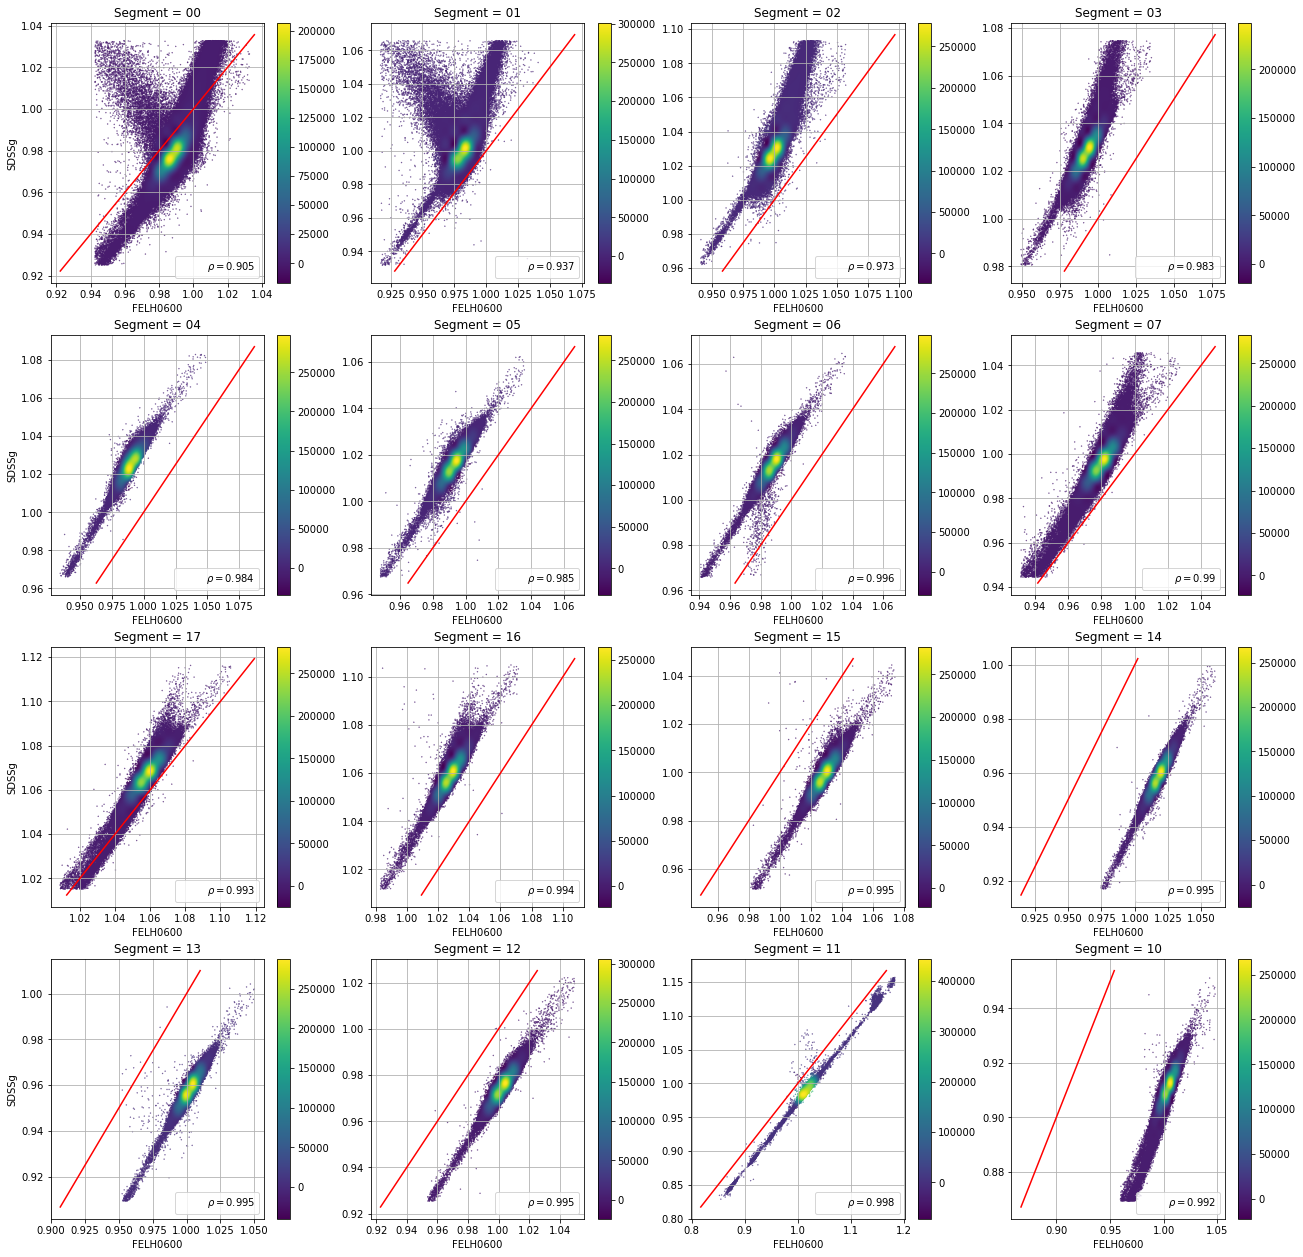

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(22,22))

for seg in range(num_segments):
    print(seg)
    
    dred = fredhf[seg+1].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan].ravel()
    dblue = fbluehf[seg+1].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan].ravel()
    dratio = ratio[seg+1].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan].ravel()
    seg_label = fredhf[seg+1].header['EXTNAME'][-2:]
    
    dred_median = np.median(dred)
    dblue_median = np.median(dblue)
    
    dred_mean = np.mean(dred)
    dblue_mean = np.mean(dblue)
    
    dred_std = np.std(dred)
    dblue_std = np.std(dblue)
    
    sig = 3.
    
    xmin_red = np.max(dred[dred<=dred_mean-sig*dred_std])
    #print(xmin_red)
    xmax_red = np.min(dred[dred>=dred_mean+sig*dred_std])
    #print(xmax_red)
    xmin_blue = np.max(dblue[dblue<=dblue_mean-sig*dblue_std])
    xmax_blue = np.min(dblue[dblue>=dblue_mean+sig*dblue_std])
    
    coeff_rb = pearson_coeff(dred,dblue)
    
    #rmask = (dred>=xmin)*(dred<=xmax)
    #bmask = (dblue>=xmin)*(dblue<=xmax)
    rmask = (dred>=xmin_red)*(dred<=xmax_red)
    bmask = (dblue>=xmin_blue)*(dblue<=xmax_blue)
    ratiomask = rmask*bmask
    
    dred_ = dred[ratiomask]
    dblue_ = dblue[ratiomask]
    if seg<4:
        j = seg
        plot = density_scatter2(dred_,dblue_,fig=fig,ax=axs[0,j],marker='.',s=0.5)
        axs[0,j].plot(np.linspace(xmin_blue,xmax_blue,100),np.linspace(xmin_blue,xmax_blue,100),color='r')        
        axs[0,j].plot([],[],ls='',label=r'$\rho = $'+'{0}'.format(coeff_rb.round(3)))
        axs[0,j].grid()
        axs[0,j].set_xlabel(filter1)#,fontsize=20)
        if j==0:
            axs[0,j].set_ylabel(filter2)#,fontsize=20)
        axs[0,j].set_title('Segment = {0}'.format(seg_label))
        axs[0,j].legend(loc='lower right',fontsize=10)
    elif seg>=4 and seg<8:
        j = seg-4
        plot = density_scatter2(dred_,dblue_,fig=fig,ax=axs[1,j],marker='.',s=0.5)
        axs[1,j].plot(np.linspace(xmin_blue,xmax_blue,100),np.linspace(xmin_blue,xmax_blue,100),color='r')        
        axs[1,j].plot([],[],ls='',label=r'$\rho = $'+'{0}'.format(coeff_rb.round(3)))
        axs[1,j].grid()
        axs[1,j].set_xlabel(filter1)#,fontsize=20)
        if j==0:
            axs[1,j].set_ylabel(filter2)#,fontsize=20)
        axs[1,j].set_title('Segment = {0}'.format(seg_label))
        axs[1,j].legend(loc='lower right',fontsize=10)
    elif seg>=8 and seg<12:
        j = seg-8
        plot = density_scatter2(dred_,dblue_,fig=fig,ax=axs[2,j],marker='.',s=0.5)
        axs[2,j].plot(np.linspace(xmin_blue,xmax_blue,100),np.linspace(xmin_blue,xmax_blue,100),color='r')
        axs[2,j].plot([],[],ls='',label=r'$\rho = $'+'{0}'.format(coeff_rb.round(3)))
        axs[2,j].grid()
        axs[2,j].set_xlabel(filter1)#,fontsize=20)
        if j==0:
            axs[2,j].set_ylabel(filter2)#,fontsize=20)
        axs[2,j].set_title('Segment = {0}'.format(seg_label))
        axs[2,j].legend(loc='lower right',fontsize=10)
    else:
        j = seg-12
        plot = density_scatter2(dred_,dblue_,fig=fig,ax=axs[3,j],marker='.',s=0.5)
        axs[3,j].plot(np.linspace(xmin_blue,xmax_blue,100),np.linspace(xmin_blue,xmax_blue,100),color='r')
        axs[3,j].plot([],[],ls='',label=r'$\rho = $'+'{0}'.format(coeff_rb.round(3)))
        axs[3,j].grid()
        axs[3,j].set_xlabel(filter1)#,fontsize=20)
        if j==0:
            axs[3,j].set_ylabel(filter2)#,fontsize=20)
        axs[3,j].set_title('Segment = {0}'.format(seg_label))
        axs[3,j].legend(loc='lower right',fontsize=10)
        
plt.savefig(outdir_plots+'plot2d_{0}_{1}_{2}_{3}_high_frequency.png'.format(filter1,date_dict[filter1],filter2,date_dict[filter2]))

# Compute histogram and 2D plot for full CCD 

In [10]:
for seg in range(1,9):
    print(seg,fredhf[seg].header['EXTNAME'])
    data_ = fredhf[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    data_ = np.flip(data_,axis=1)
    if seg==1:
        dred0 = data_
    else:
        dred0 = np.concatenate((dred0,data_),axis=1)
for seg in range(9,num_segments+1):
    seg = num_segments+9-seg
    print(seg,fredhf[seg].header['EXTNAME'])
    data_ = fredhf[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    data_ = np.flip(data_,axis=0)
    data_ = np.flip(data_,axis=1)
    if seg==16:
        dred1 = data_
    else:
        dred1 = np.concatenate((dred1,data_),axis=1)
data0red = np.concatenate((dred0,dred1),axis=0)

1 Segment00
2 Segment01
3 Segment02
4 Segment03
5 Segment04
6 Segment05
7 Segment06
8 Segment07
16 Segment10
15 Segment11
14 Segment12
13 Segment13
12 Segment14
11 Segment15
10 Segment16
9 Segment17


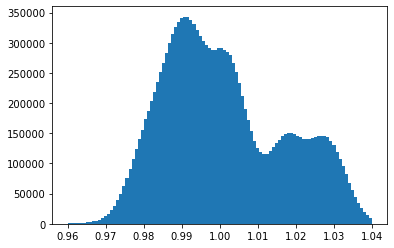

In [13]:
_ = plt.hist(data0red.ravel(),bins=100,range=(0.96,1.04))

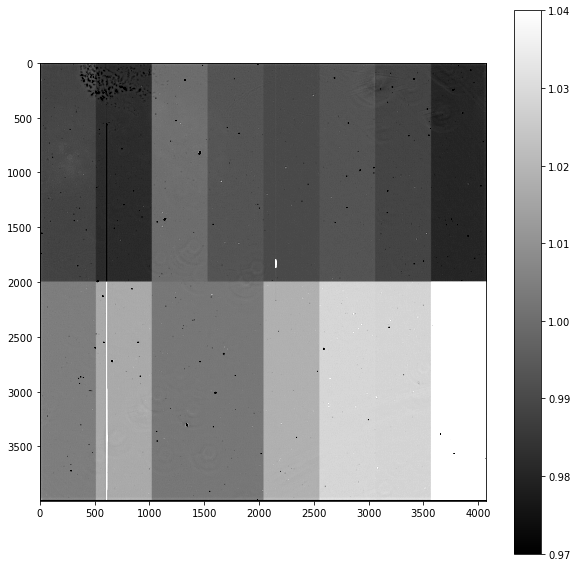

In [14]:
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
im = ax.imshow(data0red,cmap="gray",vmin=0.97,vmax=1.04)#,norm=LogNorm())
fig.colorbar(im,ax=ax)
plt.savefig(outdir_plots+'ccd_image_{0}_{1}_high_frequency.png'.format(filter1,date_dict[filter1]))

In [11]:
for seg in range(1,9):
    print(seg,fbluehf[seg].header['EXTNAME'])
    data_ = fbluehf[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    data_ = np.flip(data_,axis=1)
    if seg==1:
        dblue0 = data_
    else:
        dblue0 = np.concatenate((dblue0,data_),axis=1)
for seg in range(9,num_segments+1):
    seg = num_segments+9-seg
    print(seg,fbluehf[seg].header['EXTNAME'])
    data_ = fbluehf[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    data_ = np.flip(data_,axis=0)
    data_ = np.flip(data_,axis=1)
    if seg==16:
        dblue1 = data_
    else:
        dblue1 = np.concatenate((dblue1,data_),axis=1)
data0blue = np.concatenate((dblue0,dblue1),axis=0)

1 Segment00
2 Segment01
3 Segment02
4 Segment03
5 Segment04
6 Segment05
7 Segment06
8 Segment07
16 Segment10
15 Segment11
14 Segment12
13 Segment13
12 Segment14
11 Segment15
10 Segment16
9 Segment17


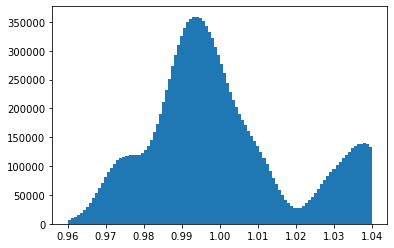

In [16]:
_ = plt.hist(data0blue.ravel(),bins=100,range=(0.96,1.04))

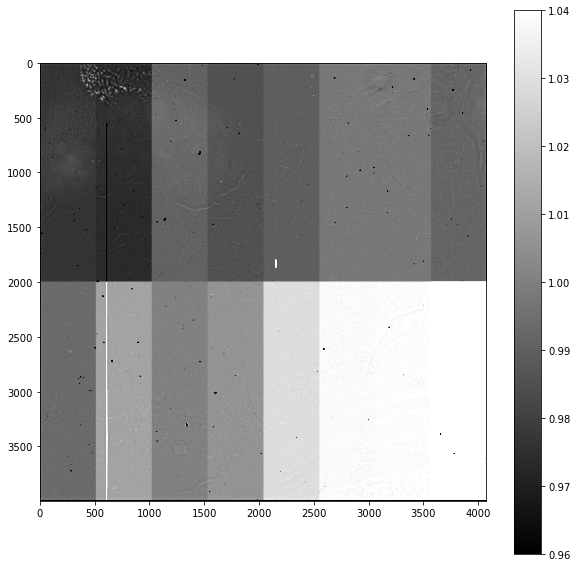

In [17]:
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
im = ax.imshow(data0blue,cmap="gray",vmin=0.96,vmax=1.04)#,norm=LogNorm())
fig.colorbar(im,ax=ax)
plt.savefig(outdir_plots+'ccd_image_{0}_{1}_high_frequency.png'.format(filter2,date_dict[filter2]))

In [11]:
for seg in range(1,9):
    print(seg,ratio[seg].header['EXTNAME'])
    data_ = ratio[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    data_ = np.flip(data_,axis=1)
    if seg==1:
        dratio0 = data_
    else:
        dratio0 = np.concatenate((dratio0,data_),axis=1)
for seg in range(9,num_segments+1):
    seg = num_segments+9-seg
    print(seg,ratio[seg].header['EXTNAME'])
    data_ = ratio[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    data_ = np.flip(data_,axis=0)
    data_ = np.flip(data_,axis=1)
    if seg==16:
        dratio1 = data_
    else:
        dratio1 = np.concatenate((dratio1,data_),axis=1)
data0ratio = np.concatenate((dratio0,dratio1),axis=0)

1 Segment00
2 Segment01
3 Segment02
4 Segment03
5 Segment04
6 Segment05
7 Segment06
8 Segment07
16 Segment10
15 Segment11
14 Segment12
13 Segment13
12 Segment14
11 Segment15
10 Segment16
9 Segment17


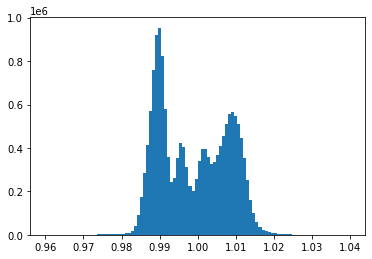

In [12]:
_ = plt.hist(data0ratio.ravel(),bins=100,range=(0.96,1.04))

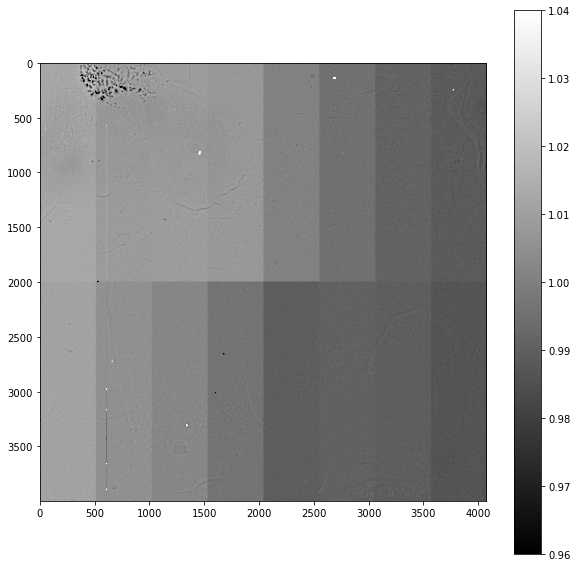

In [13]:
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
im = ax.imshow(data0ratio,cmap="gray",vmin=0.96,vmax=1.04)#,norm=LogNorm())
fig.colorbar(im,ax=ax)
plt.savefig(outdir_plots+'ccd_image_ratio_{0}_{1}_{2}_{3}_high_frequency.png'.format(filter1,date_dict[filter1],filter2,date_dict[filter2]))

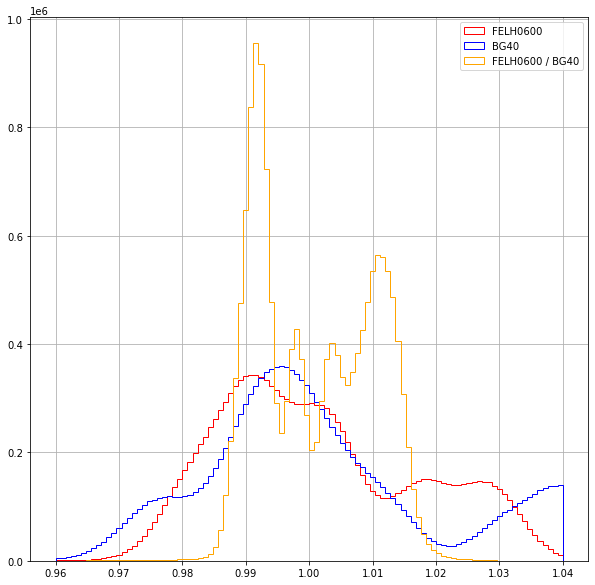

In [21]:
data0red_shift = np.median(data0red.ravel())-1.
data0blue_shift = np.median(data0blue.ravel())-1.
data0ratio_shift = np.median(data0ratio.ravel())-1.

fig = plt.figure(figsize=(10,10))
_ = plt.hist(data0red.ravel()-data0red_shift,bins=100,range=(0.96,1.04),histtype='step',color='r',label=filter1)
_ = plt.hist(data0blue.ravel()-data0blue_shift,bins=100,range=(0.96,1.04),histtype='step',color='b',label=filter2)
_ = plt.hist(data0ratio.ravel()-data0ratio_shift,bins=100,range=(0.96,1.04),histtype='step',color='orange',label=filter1+' / '+filter2)
plt.grid()
plt.legend()
plt.savefig(outdir_plots+'histograms_full_ccd_{0}_{1}_{2}_{3}_high_frequency.png'.format(filter1,date_dict[filter1],filter2,date_dict[filter2]))

In [21]:
redmask = (data0red.ravel()>=xmin)*(data0red.ravel()<=xmax)
bluemask = (data0blue.ravel()>=xmin)*(data0blue.ravel()<=xmax)
totalmask = redmask*bluemask

data0red_ = data0red.ravel()[totalmask]
data0blue_ = data0blue.ravel()[totalmask]

In [22]:
coeff_ccd = pearson_coeff(data0red_,data0blue_)

In [23]:
print(coeff_ccd)

0.9101148891197344


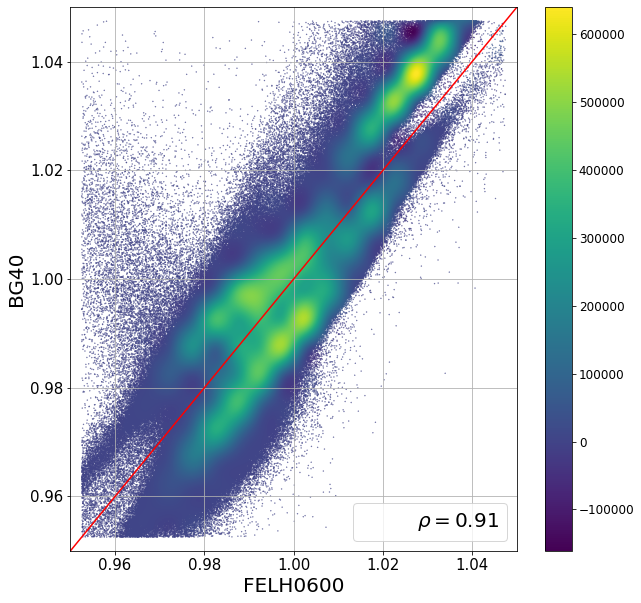

In [24]:
plot = density_scatter(data0red_,data0blue_,marker='.',s=0.5)
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.plot(np.linspace(xmin,xmax,100),np.linspace(xmin,xmax,100),color='r')
plt.plot([],[],ls='',label=r'$\rho = $'+'{0}'.format(coeff_ccd.round(3)))
plt.grid()
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(filter1,fontsize=20)
plt.ylabel(filter2,fontsize=20)
plt.legend(fontsize=20)
plt.savefig(outdir_plots+'plot2d_full_ccd_{0}_{1}_{2}_{3}_high_frequency.png'.format(filter1,date_dict[filter1],filter2,date_dict[filter2]))